# survival.ipynb
Survival analyses on the pedpancan cohort.

## TODO
- add extent of resection, sex, age as covariates in cox models
- add tumor purity, ibid. (@Rishaan)
- make a publication-ready plot
- Expand cohort:
    - SJ RTCG
    - Cancer research UK

In [1]:
library(tidyverse)
library(readxl)
library(dplyr)
library(stringr)
library(naniar) #for replace with Nas function
library(survival)
library(survminer)
library(RColorBrewer)
library(janitor)
library(rio)
#library(labelled)
library(gt)
library(gtsummary)
library(ggsurvfit)
library(extrafont)
library(svglite)

extrafont::font_import(pattern="Arial",prompt=FALSE)
extrafont::loadfonts()

sessionInfo()

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Registering fonts with R

Scanning ttf files in /Library/Fonts/, /System/Library/Fonts, /System/Library/Fonts/Supplemental, ~/Library/Fonts/ ...

Extracting .afm files from .ttf files...

/System/Library/Fonts/Supplemen

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/sunitasridhar/miniconda3/envs/r-survival/lib/libopenblasp-r0.3.27.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] svglite_2.1.3      extrafont_0.19     ggsurvfit_1.1.0    gtsummary_2.0.0   
 [5] gt_0.11.0          rio_1.1.1          janitor_2.2.0      RColorBrewer_1.1-3
 [9] survminer_0.4.9    ggpubr_0.6.0       survival_3.7-0     naniar_1.1.0      
[13] readxl_1.4.3       lubridate_1.9.3    forcats_1.0.0      stringr_1.5.1     
[17] dplyr_1.1.4        purrr_1.0.2        readr_2.1.5        tidyr_1.3.1       
[21] tibble_3.2.1       ggplot2_3.5.1      tidyverse_2.0.0   

loaded via a na

In [2]:
## OSC create an output directory if it doesn't exist
dir.create('../out', showWarnings = FALSE)

load_survival_data <- function(path, tumor_types=NULL){
  ## path: path to data/Supplementary Tables.xlsx
  ## tumor_types: (optional) may specify only a subset of tumor types present in the dataset.
  combinedsurv <- read_excel(path, sheet="1. Patients")
  # Subset for tumor types if specified
  if (!is.null(tumor_types)){
    combinedsurv <- combinedsurv %>%
    filter(str_detect(cancer_type, tumor_types))
  }

  # Drop NAs
  combinedsurv <- combinedsurv %>%
    filter(complete.cases(amplicon_class,OS_status,OS_months)) %>%
    mutate(OS_months = as.numeric(OS_months)) %>%
  # Censor at 5 years = 60 months
    mutate(OS_months_5y = if_else(OS_months < 60, OS_months, 60)) %>%
    mutate(OS_status_5y = if_else(OS_months <= 60, OS_status, "Alive")) %>%
    mutate(OS_status_5y = if_else(OS_status_5y == "Alive", 0, 1)) %>%
  # get ecDNA status
    mutate(ecDNA_status = if_else(amplicon_class == "ecDNA", "ecDNA+", "ecDNA-")) %>%
  # convert to factors
    mutate(ecDNA_status = factor(ecDNA_status)) %>%
    mutate(amplicon_class = factor(amplicon_class)) %>%
    mutate(cancer_type = factor(cancer_type))
    
  return(combinedsurv)
}

cox_plot <- function(data,outfile){
  ## OSC function to perform a Cox regression and generate the plot
  coxph(Surv(OS_months, OS_status) ~ ecDNA_status + strata(cancer_type), data = data)
}

km_plot <- function(survObj,outfile=NULL){
  ## OSC function to perform a KM analysis and generate the plot
  if (length(survObj$n) == 2){
    colors = c('blue', 'red')
    labels = c('ecDNA-', 'ecDNA+')
  } else if (length(survObj$n) == 5){
    colors = c('magenta','darkgreen','red','cyan','dodgerblue')
    labels = c('BFB','Complex noncyclic','ecDNA','Linear','no fSCNA')
  } else if (length(survObj$n) == 4){
    colors = c('darkgreen','red','magenta','dodgerblue')
    labels = c('Highly rearranged','ecDNA','Linear','no fSCNA')
  } else if (length(survObj$n) == 3){
    colors = c('magenta','red','dodgerblue')
    labels = c('chromosomal','ecDNA','no fSCNA')
  }
  plt <- survObj %>% 
   ggsurvfit(linewidth=0.5) +
   labs(x = 'Follow-up time (Months)',
        y = 'Overall Survival') +
   scale_color_manual(values = colors,
                      labels = labels) +
   scale_fill_manual(values = colors,
                     labels = labels) +
   scale_y_continuous(limits=c(0, 1))+
   add_censor_mark(size = .5, alpha = 1) +
   add_risktable(risktable_stats = "n.risk", size=2,
                 theme = theme_risktable_default(axis.text.y.size = 7,
                                    plot.title.size = 7)) +
   add_risktable_strata_symbol(size=4) + 
   theme_classic(base_size=7, base_family="Arial",) +
   theme(axis.text = element_text(size=7,colour="black"),
         legend.position = "bottom",
   )
  if (length(survObj$n) <=2){
    plt <- plt + add_confidence_interval()
  }
  
  if(!is.null(outfile)){
    pdf.options(encoding='ISOLatin2.enc')
    pdfName = paste(outfile, ".pdf", sep="")
    pngName = paste(outfile, ".png", sep="")
    svgName = paste(outfile, ".svg", sep = "")
    ggsave(path="out", filename=pdfName, device="pdf", width=3, height=3.5, units='in')
    ggsave(path="out", device="png", filename=pngName, width=3, height=3.5, units='in')
    ggsave(path="out", device="svg", filename=svgName, width=3, height=3.5, units='in')
  }
  return(plt)
}

# Kaplan-Meier regressions

[1] "/Users/sunitasridhar/Desktop/Research_Project/GitHub/2024-07-17_survival"


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”


Call:
survdiff(formula = formula, data = data)

                       N Observed Expected (O-E)^2/E (O-E)^2/V
ecDNA_status=ecDNA- 1850      337    396.4       8.9       114
ecDNA_status=ecDNA+  180       93     33.6     105.1       114

 Chisq= 114  on 1 degrees of freedom, p= <2e-16 

[1] 2030   12

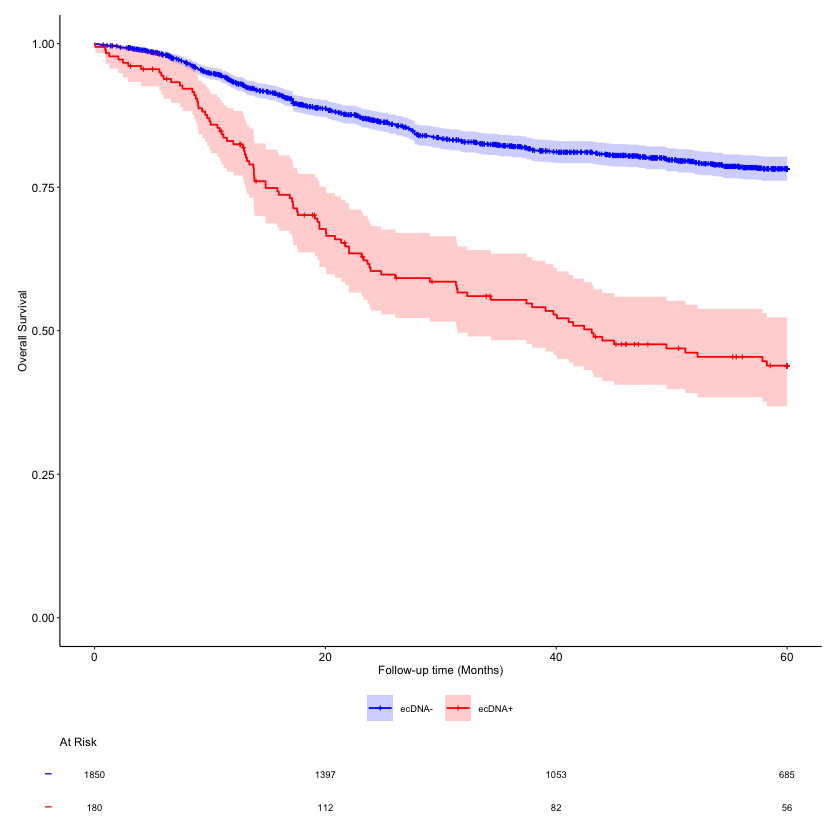

In [3]:
# KM by ecDNA status of combined cohort, censored at 5 years

print(getwd())
data <- load_survival_data("../data/Supplementary Tables.xlsx")
formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status
km <- survfit2(formula=formula, data=data)
km_plot(km)
#km_plot(km, "km_surv_all_5year")
logrank <- survdiff(formula,data)
logrank
dim(data)

In [4]:
# KM by amplicon typeclass_map <- c("ecDNA" = "ecDNA",
               "BFB" = "chromosomal",
               "Complex noncyclic" = "chromosomal",
               "Linear" = "chromosomal"
)
data <- load_survival_data("../data/Supplementary Tables.xlsx") %>%
  mutate(amplicon_class = recode(amplicon_class, !!!class_map))
formula <- Surv(OS_months_5y, OS_status_5y) ~ amplicon_class
km <- survfit2(formula=formula, data=data)
km_plot(km)
#km_plot(km, "km_class_all_5year")
logrank <- pairwise_survdiff(formula,data,p.adjust.method="BH",rho=0)
logrank

ERROR: Error in parse(text = x, srcfile = src): <text>:2:37: unexpected ','
1: # KM by amplicon typeclass_map <- c("ecDNA" = "ecDNA",
2:                "BFB" = "chromosomal",
                                       ^


[1] EPN   HGG   LGG   SARC  NBL   MST   CPG   MBL   CPT   GCT   PBL   EMBT 
[13] ETMR  MPNST OST   RBL   RMS   WLM  
18 Levels: CPG CPT EMBT EPN ETMR GCT HGG LGG MBL MPNST MST NBL OST PBL ... WLM

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”


Call:
survdiff(formula = formula, data = dd2)

                       N Observed Expected (O-E)^2/E (O-E)^2/V
ecDNA_status=ecDNA- 1515      284    348.8        12       114
ecDNA_status=ecDNA+  210      106     41.2       102       114

 Chisq= 114  on 1 degrees of freedom, p= <2e-16 

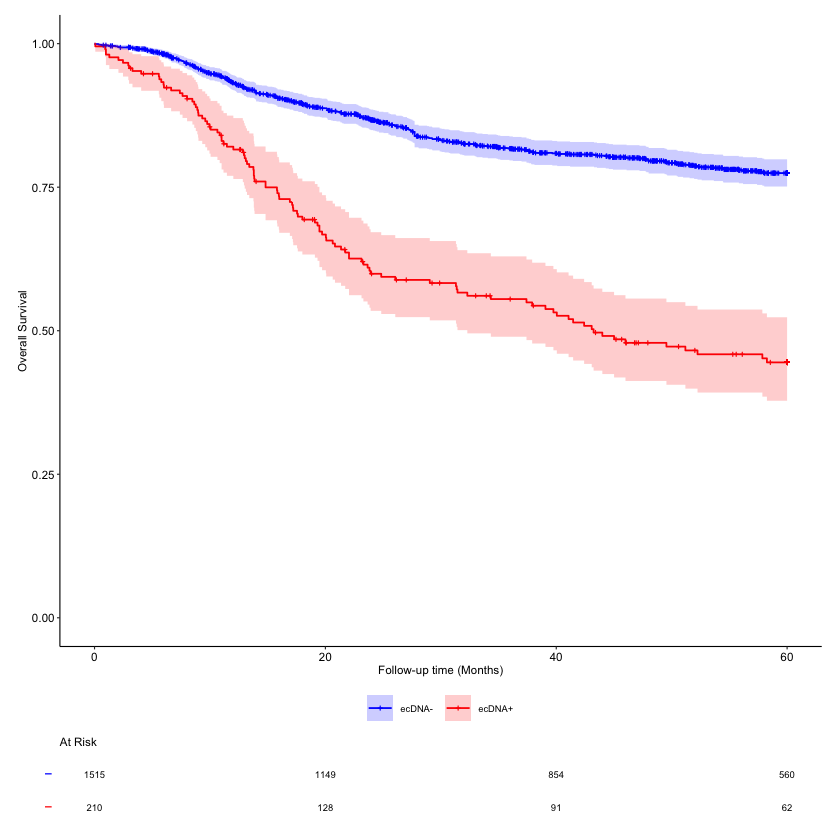

In [5]:
# KM by ecDNA status of tumor types with at least 1 sample with ecDNA, censored at 5 years
dd2 <- load_survival_data("../data/Supplementary Tables With ICGC.xlsx") %>%
  group_by(cancer_type) %>%
  filter(any(amplicon_class == 'ecDNA')) %>%
  ungroup()
dd2$cancer_type <- droplevels(dd2$cancer_type) # drop unused levels
dd2$cancer_type %>% unique() # print remaining levels

formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status
km <- survfit2(formula=formula, data=dd2)
km_plot(km)
#km_plot(km, "km_surv_subset_5year")
logrank <- survdiff(formula,dd2)
logrank


[1] EPN   HGG   LGG   SARC  NBL   MST   CPG   MBL   CPT   GCT   PBL   EMBT 
[13] ETMR  MPNST OST   RBL   RMS   WLM  
18 Levels: CPG CPT EMBT EPN ETMR GCT HGG LGG MBL MPNST MST NBL OST PBL ... WLM

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label


	Pairwise comparisons using Log-Rank test 

data:  dd2 and amplicon_class 

                 chromosomal ecDNA  
ecDNA            0.11        -      
No amplification 8.4e-07     < 2e-16

P value adjustment method: BH 

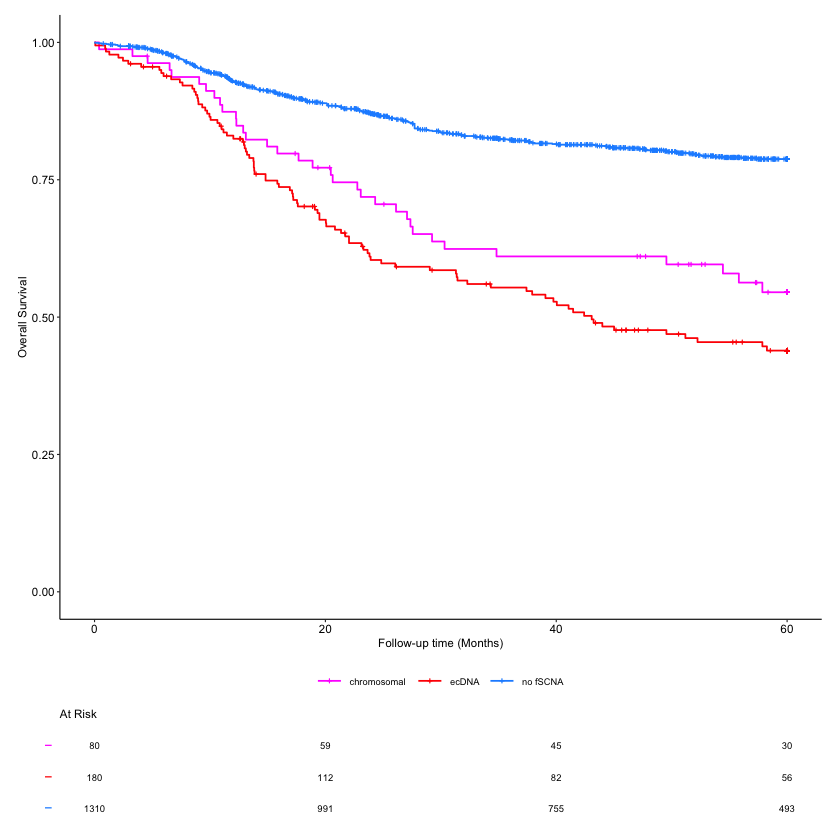

In [6]:
# KM by ecDNA status of tumor types with at least 1 sample with ecDNA, censored at 5 years
class_map <- c("ecDNA" = "ecDNA",
               "BFB" = "chromosomal",
               "Complex noncyclic" = "chromosomal",
               "Linear" = "chromosomal"
)
dd2 <- load_survival_data("../data/Supplementary Tables.xlsx") %>%
  mutate(amplicon_class = recode(amplicon_class, !!!class_map)) %>%
  group_by(cancer_type) %>%
  filter(any(amplicon_class == 'ecDNA')) %>%
  ungroup()
dd2$cancer_type <- droplevels(dd2$cancer_type) # drop unused levels
dd2$cancer_type %>% unique() # print remaining levels

formula = Surv(OS_months_5y, OS_status_5y) ~ amplicon_class
km = survfit2(formula=formula, data = dd2 )
#km_plot(km, "km_class_subset_5year")
km_plot(km)
logrank <- pairwise_survdiff(formula,dd2,p.adjust.method="BH",rho=0)
logrank

# Cox regressions

We include tumor types which satisfy the following:
- At least 10 patients
- At least one death
- At least one ecDNA

In [7]:
dd3 <-load_survival_data("../data/Supplementary Tables.xlsx") %>%
  group_by(cancer_type) %>%
  filter(any(amplicon_class == 'ecDNA')) %>%
  filter(n() >= 10) %>%
  ungroup()
dim(dd3)
dd3$cancer_type %>% unique()
dd3$cancer_type <- droplevels(dd3$cancer_type)

dd3 %>% group_by(ecDNA_status, cancer_type) %>%
  summarise(n=n())%>%
  spread(cancer_type, n)
m1_unstrat <- coxph(Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + cancer_type, data = dd3)
m1_unstrat
#adding sex to the cox regression
m3 <- coxph(Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + cancer_type + sex, data = dd3)
m3
#adding age at diagnosis to the cox regression
m4 <- coxph(Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + cancer_type + sex + age_at_diagnosis, data = dd3)
m4
# Check proportionality assumption
coxZph <-cox.zph(m1_unstrat) 
print("coxZph: ")
print(coxZph)


[1] 1549   12

[1] EPN  HGG  LGG  SARC NBL  CPG  MBL  CPT  GCT  PBL  EMBT OST  RBL  RMS  WLM 
45 Levels: ACC ATRT BENG BTNOS CARC CHDM CNSL CPG CPT DSRCT EBVT EMBT ... WLM

`summarise()` has grouped output by 'ecDNA_status'. You can override using the
`.groups` argument.


ecDNA_status,CPG,CPT,EMBT,EPN,GCT,HGG,LGG,MBL,NBL,OST,PBL,RBL,RMS,SARC,WLM
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ecDNA-,77,36,12,123,32,222,444,232,50,28,16,24,22,32,27
ecDNA+,1,3,3,1,2,54,1,43,11,26,1,6,14,5,1


Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  12 ; coefficient may be infinite. ”


Call:
coxph(formula = Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + 
    cancer_type, data = dd3)

                         coef  exp(coef)   se(coef)      z        p
ecDNA_statusecDNA+  4.698e-01  1.600e+00  1.285e-01  3.656 0.000256
cancer_typeCPT      7.287e-01  2.072e+00  7.073e-01  1.030 0.302897
cancer_typeEMBT     2.107e+00  8.225e+00  6.715e-01  3.138 0.001701
cancer_typeEPN      9.140e-01  2.494e+00  5.590e-01  1.635 0.102058
cancer_typeGCT      8.707e-02  1.091e+00  8.660e-01  0.101 0.919916
cancer_typeHGG      3.130e+00  2.287e+01  5.060e-01  6.185 6.21e-10
cancer_typeLGG     -1.202e+00  3.006e-01  6.268e-01 -1.918 0.055147
cancer_typeMBL      1.191e+00  3.292e+00  5.201e-01  2.291 0.021981
cancer_typeNBL      1.030e+00  2.800e+00  5.844e-01  1.762 0.078114
cancer_typeOST      1.636e+00  5.135e+00  5.518e-01  2.965 0.003028
cancer_typePBL      1.478e+00  4.383e+00  7.638e-01  1.935 0.053047
cancer_typeRBL     -1.489e+01  3.403e-07  1.127e+03 -0.013 0.989452
cancer_typeRM

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  12 ; coefficient may be infinite. ”


Call:
coxph(formula = Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + 
    cancer_type + sex, data = dd3)

                         coef  exp(coef)   se(coef)      z        p
ecDNA_statusecDNA+  4.789e-01  1.614e+00  1.301e-01  3.680 0.000233
cancer_typeCPT      9.658e-01  2.627e+00  7.641e-01  1.264 0.206207
cancer_typeEMBT     2.261e+00  9.590e+00  7.652e-01  2.954 0.003133
cancer_typeEPN      1.191e+00  3.291e+00  6.292e-01  1.893 0.058339
cancer_typeGCT      3.291e-01  1.390e+00  9.129e-01  0.360 0.718509
cancer_typeHGG      3.386e+00  2.955e+01  5.826e-01  5.812 6.18e-09
cancer_typeLGG     -9.388e-01  3.911e-01  6.901e-01 -1.360 0.173721
cancer_typeMBL      1.435e+00  4.199e+00  5.953e-01  2.410 0.015947
cancer_typeNBL      1.121e+00  3.068e+00  6.672e-01  1.680 0.092950
cancer_typeOST      1.826e+00  6.212e+00  6.250e-01  2.923 0.003472
cancer_typePBL      1.714e+00  5.552e+00  8.166e-01  2.099 0.035795
cancer_typeRBL     -1.478e+01  3.825e-07  1.198e+03 -0.012 0.990159
cancer_

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  12 ; coefficient may be infinite. ”


Call:
coxph(formula = Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + 
    cancer_type + sex + age_at_diagnosis, data = dd3)

                         coef  exp(coef)   se(coef)      z        p
ecDNA_statusecDNA+  5.655e-01  1.760e+00  1.353e-01  4.180 2.91e-05
cancer_typeCPT      8.234e-01  2.278e+00  7.649e-01  1.076  0.28175
cancer_typeEMBT     2.213e+00  9.143e+00  7.652e-01  2.892  0.00383
cancer_typeEPN      1.182e+00  3.260e+00  6.293e-01  1.878  0.06041
cancer_typeGCT      3.393e-01  1.404e+00  9.129e-01  0.372  0.71015
cancer_typeHGG      3.470e+00  3.214e+01  5.828e-01  5.954 2.61e-09
cancer_typeLGG     -9.305e-01  3.944e-01  6.901e-01 -1.348  0.17754
cancer_typeMBL      1.411e+00  4.099e+00  5.954e-01  2.369  0.01782
cancer_typeNBL      9.583e-01  2.607e+00  6.693e-01  1.432  0.15217
cancer_typeOST      2.092e+00  8.101e+00  6.500e-01  3.218  0.00129
cancer_typePBL      1.661e+00  5.265e+00  8.168e-01  2.034  0.04198
cancer_typeRBL     -1.505e+01  2.900e-07  1.188e+03 -0.0

[1] "coxZph: "
             chisq df     p
ecDNA_status  1.07  1 0.300
cancer_type  22.14 14 0.076
GLOBAL       22.95 15 0.085


In [8]:
#The `cox.zph()` function tests the proportionality assumption. The result is borderline, suggesting that this 
#assumption may be violated w.r.t. the cancer_type variable. 
#Therefore, we perform Cox regression w.r.t. ecDNA, stratifying by cancer_type. The result is the unchanged.

m1 <- coxph(Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + strata(cancer_type), data = dd3)
m1
# Check proportionality assumption
coxZph <-cox.zph(m1) 
print("coxZph: ")
print(coxZph)


Call:
coxph(formula = Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + 
    strata(cancer_type), data = dd3)

                     coef exp(coef) se(coef)     z        p
ecDNA_statusecDNA+ 0.4669    1.5950   0.1282 3.641 0.000272

Likelihood ratio test=12.33  on 1 df, p=0.0004449
n= 1549, number of events= 350 

[1] "coxZph: "
             chisq df   p
ecDNA_status 0.705  1 0.4
GLOBAL       0.705  1 0.4


# Survival of H3K27 mutant HGG.
Cox analysis: TP53 mutant is really bad for your prognosis, ecDNA doesn't matter.

[1] 13

Call:
coxph(formula = formula, data = dd4)

                      coef exp(coef) se(coef)      z       p
ecDNA_statusecDNA+ -0.1252    0.8823   0.2401 -0.522 0.60201
TP53_mutantTRUE     0.6085    1.8377   0.2080  2.925 0.00345

Likelihood ratio test=8.69  on 2 df, p=0.01295
n= 112, number of events= 107 

[1] "coxZph: "
              chisq df    p
ecDNA_status 1.3722  1 0.24
TP53_mutant  0.0652  1 0.80
GLOBAL       1.3817  2 0.50


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”


Call:
survdiff(formula = formula, data = dd4)

                     N Observed Expected (O-E)^2/E (O-E)^2/V
ecDNA_status=ecDNA- 89       84       84  4.78e-06  2.25e-05
ecDNA_status=ecDNA+ 23       23       23  1.75e-05  2.25e-05

 Chisq= 0  on 1 degrees of freedom, p= 1 

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”


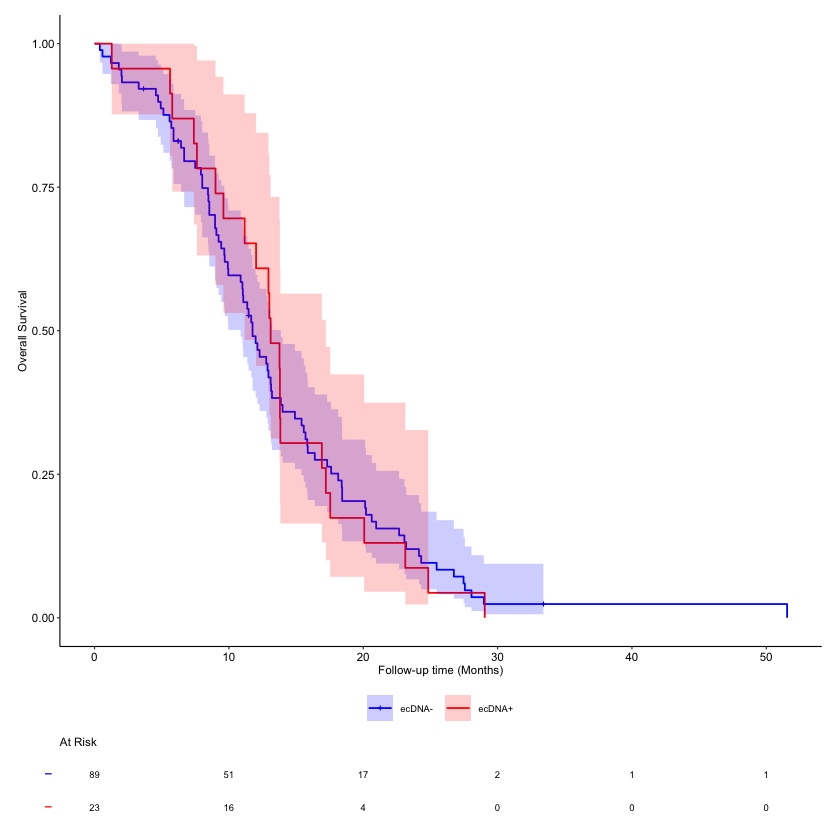

Call:
survdiff(formula = formula, data = dd4)

                   N Observed Expected (O-E)^2/E (O-E)^2/V
TP53_mutant=FALSE 54       49     63.3      3.22       8.5
TP53_mutant=TRUE  58       58     43.7      4.67       8.5

 Chisq= 8.5  on 1 degrees of freedom, p= 0.004 

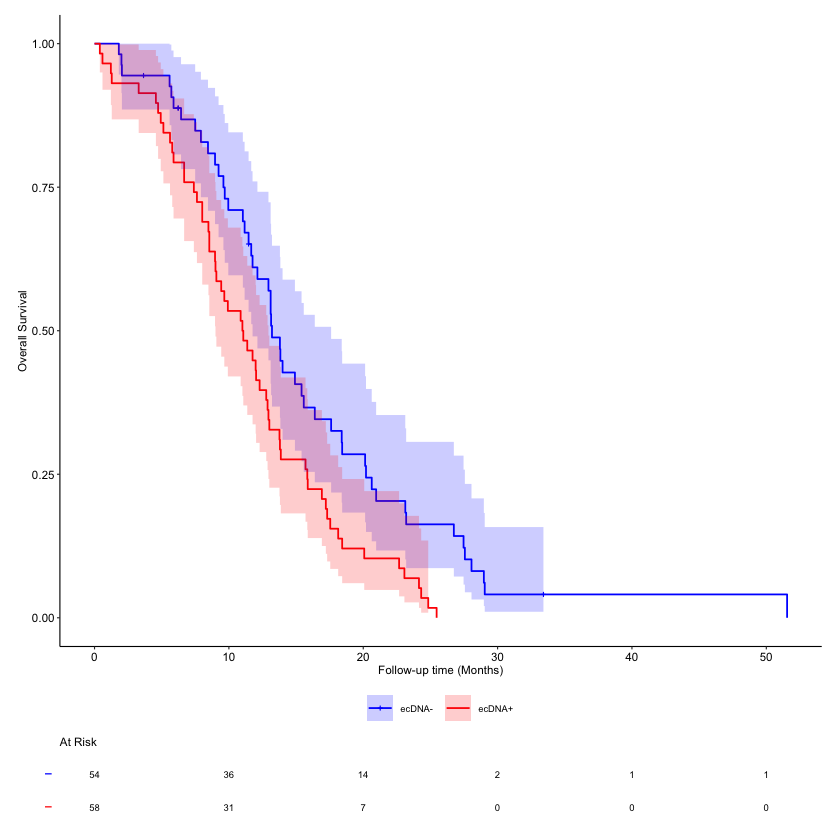

In [9]:
dd4 <- load_survival_data("../data/Supplementary Tables.xlsx") %>%
  filter(str_detect(cancer_subclass, "K27")) %>%
  mutate(TP53_mutant = ifelse(str_detect(cancer_subclass, "TP53"), TRUE, FALSE))

length(dd4)

formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + TP53_mutant
m2 <- coxph(formula = formula, data = dd4)
m2
# Check proportionality assumption
coxZph <-cox.zph(m2) 
print("coxZph: ")
print(coxZph)

formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status
km <- survfit2(formula=formula, data=dd4)
km_plot(km)
#km_plot(km, "km_surv_all_5year")
logrank <- survdiff(formula,dd4)
logrank

formula <- Surv(OS_months_5y, OS_status_5y) ~ TP53_mutant
km <- survfit2(formula=formula, data=dd4)
km_plot(km)
#km_plot(km, "km_surv_all_5year")
logrank <- survdiff(formula,dd4)
logrank


# Survival of subtypes of HGG.

In [23]:
dd5 <- load_survival_data("../data/Supplementary Tables With ICGC.xlsx") %>%
  filter(str_detect(cancer_type, "MBL"))

length(dd5)

formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + cancer_subclass
m2 <- coxph(formula = formula, data = dd5)
m2
# Check proportionality assumption
coxZph <-cox.zph(m2) 
print("coxZph: ")
print(coxZph)

km <- survfit2(formula=formula, data=dd5)
km_plot(km)
#km_plot(km, "km_surv_all_5year")
logrank <- survdiff(formula,dd5)
logrank

[1] 12

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  2,3,4,5,6 ; coefficient may be infinite. ”


Call:
coxph(formula = formula, data = dd5)

                        coef exp(coef)  se(coef)     z        p
ecDNA_statusecDNA+ 9.534e-01 2.594e+00 2.528e-01 3.771 0.000163
cancer_subclassG3  1.729e+01 3.229e+07 3.092e+03 0.006 0.995538
cancer_subclassG4  1.603e+01 9.122e+06 3.092e+03 0.005 0.995864
cancer_subclassNOS 1.607e+01 9.523e+06 3.092e+03 0.005 0.995853
cancer_subclassSHH 1.668e+01 1.752e+07 3.092e+03 0.005 0.995696
cancer_subclassWNT 1.512e+01 3.692e+06 3.092e+03 0.005 0.996098

Likelihood ratio test=40.79  on 6 df, p=3.181e-07
n= 429, number of events= 79 
   (1 observation deleted due to missingness)

[1] "coxZph: "
                chisq df      p
ecDNA_status     7.25  1 0.0071
cancer_subclass  2.66  5 0.7518
GLOBAL          12.27  6 0.0562


ERROR: [1m[33mError[39m in `palette()`:[22m
[1m[22m[33m![39m Insufficient values in manual scale. 11 needed but only 1 provided.


[1] 12

Call:
coxph(formula = formula, data = dd5)

                     coef exp(coef) se(coef)     z     p
ecDNA_statusecDNA+ 0.2311    1.2600   0.1697 1.362 0.173

Likelihood ratio test=1.78  on 1 df, p=0.182
n= 252, number of events= 189 

[1] "coxZph: "
             chisq df    p
ecDNA_status 0.693  1 0.41
GLOBAL       0.693  1 0.41


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”


Call:
survdiff(formula = formula, data = dd5)

                      N Observed Expected (O-E)^2/E (O-E)^2/V
ecDNA_status=ecDNA- 199      143    150.5     0.377      1.86
ecDNA_status=ecDNA+  53       46     38.5     1.477      1.86

 Chisq= 1.9  on 1 degrees of freedom, p= 0.2 

ERROR: [1m[33mError[39m in `palette()`:[22m
[1m[22m[33m![39m Insufficient values in manual scale. 6 needed but only 1 provided.


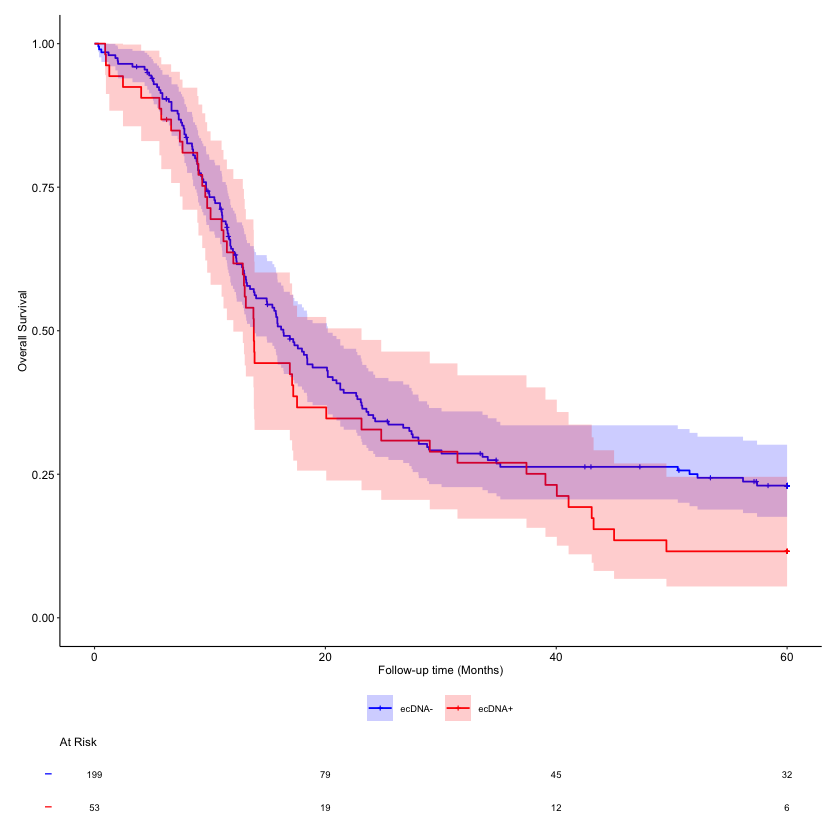

In [21]:
dd5 <- load_survival_data("../data/Supplementary Tables.xlsx") %>%
  filter(str_detect(cancer_subclass, "HGG") | str_detect(cancer_subclass, "DMG"))

length(dd5)

formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status
m2 <- coxph(formula = formula, data = dd5)
m2
# Check proportionality assumption
coxZph <-cox.zph(m2) 
print("coxZph: ")
print(coxZph)

formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status
km <- survfit2(formula=formula, data=dd5)
km_plot(km)
#km_plot(km, "km_surv_all_5year")
logrank <- survdiff(formula,dd5)
logrank

formula <- Surv(OS_months_5y, OS_status_5y) ~ cancer_subclass
km <- survfit2(formula=formula, data=dd5)
km_plot(km)
#km_plot(km, "km_surv_all_5year")
logrank <- survdiff(formula,dd5)
logrank


# Survival including ICGC cohort

[1] "/Users/sunitasridhar/Desktop/Research_Project/GitHub/2024-07-17_survival"


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”


Call:
survdiff(formula = formula, data = data)

                       N Observed Expected (O-E)^2/E (O-E)^2/V
ecDNA_status=ecDNA- 1966      352    419.3      10.8       125
ecDNA_status=ecDNA+  219      107     39.7     114.4       125

 Chisq= 125  on 1 degrees of freedom, p= <2e-16 

[1] 2185   12

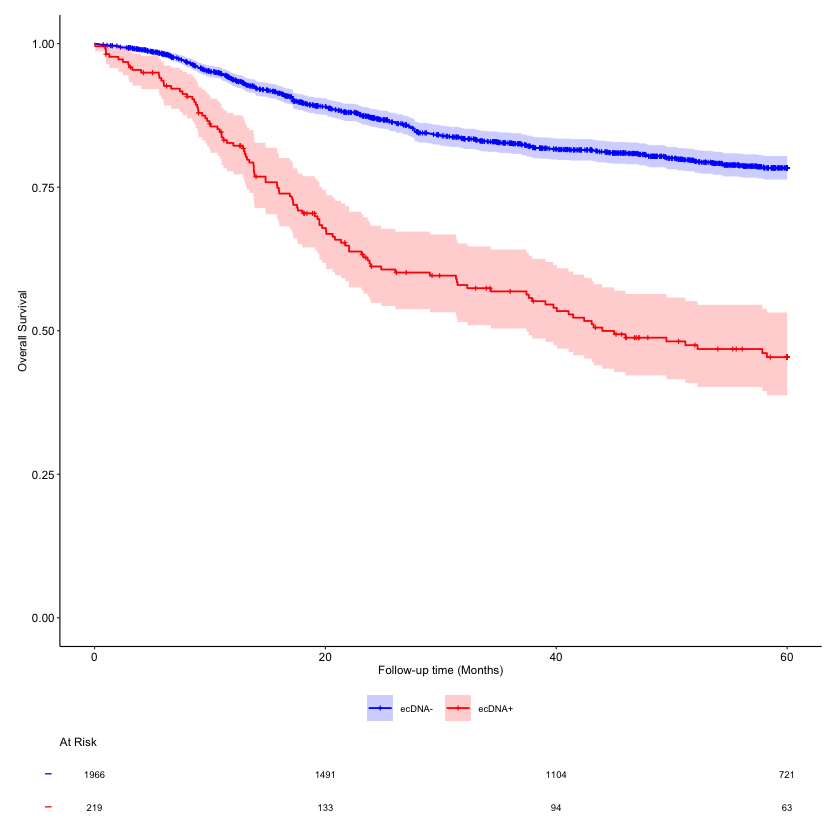

In [16]:
# KM by ecDNA status of combined cohort, censored at 5 years for data including

print(getwd())
data <- load_survival_data("../data/Supplementary Tables With ICGC.xlsx")
formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status
km <- survfit2(formula=formula, data=data)
km_plot(km)
#km_plot(km, "km_surv_all_5year")
logrank <- survdiff(formula,data)
logrank
dim(data)

In [10]:
# KM by amplicon typeclass_map <- c("ecDNA" = "ecDNA",
               "BFB" = "chromosomal",
               "Complex noncyclic" = "chromosomal",
               "Linear" = "chromosomal"
)
data <- load_survival_data("../data/Supplementary Tables With ICGC.xlsx") %>%
  mutate(amplicon_class = recode(amplicon_class, !!!class_map))
formula <- Surv(OS_months_5y, OS_status_5y) ~ amplicon_class
km <- survfit2(formula=formula, data=data)
km_plot(km)
#km_plot(km, "km_class_all_5year")
logrank <- pairwise_survdiff(formula,data,p.adjust.method="BH",rho=0)
logrank

ERROR: Error in parse(text = x, srcfile = src): <text>:2:37: unexpected ','
1: # KM by amplicon typeclass_map <- c("ecDNA" = "ecDNA",
2:                "BFB" = "chromosomal",
                                       ^


In [ ]:
# KM by ecDNA status of tumor types with at least 1 sample with ecDNA, censored at 5 years
dd2 <- load_survival_data("../data/Supplementary Tables.xlsx") %>%
  group_by(cancer_type) %>%
  filter(any(amplicon_class == 'ecDNA')) %>%
  ungroup()
dd2$cancer_type <- droplevels(dd2$cancer_type) # drop unused levels
dd2$cancer_type %>% unique() # print remaining levels

formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status
km <- survfit2(formula=formula, data=dd2)
km_plot(km)
#km_plot(km, "km_surv_subset_5year")
logrank <- survdiff(formula,dd2)
logrank


[1] EPN   HGG   LGG   SARC  NBL   MST   CPG   MBL   CPT   GCT   PBL   EMBT 
[13] ETMR  MPNST OST   RBL   RMS   WLM  
18 Levels: CPG CPT EMBT EPN ETMR GCT HGG LGG MBL MPNST MST NBL OST PBL ... WLM

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label


	Pairwise comparisons using Log-Rank test 

data:  dd2 and amplicon_class 

                 chromosomal ecDNA  
ecDNA            1.2e-05     -      
No amplification 0.0043      < 2e-16

P value adjustment method: BH 

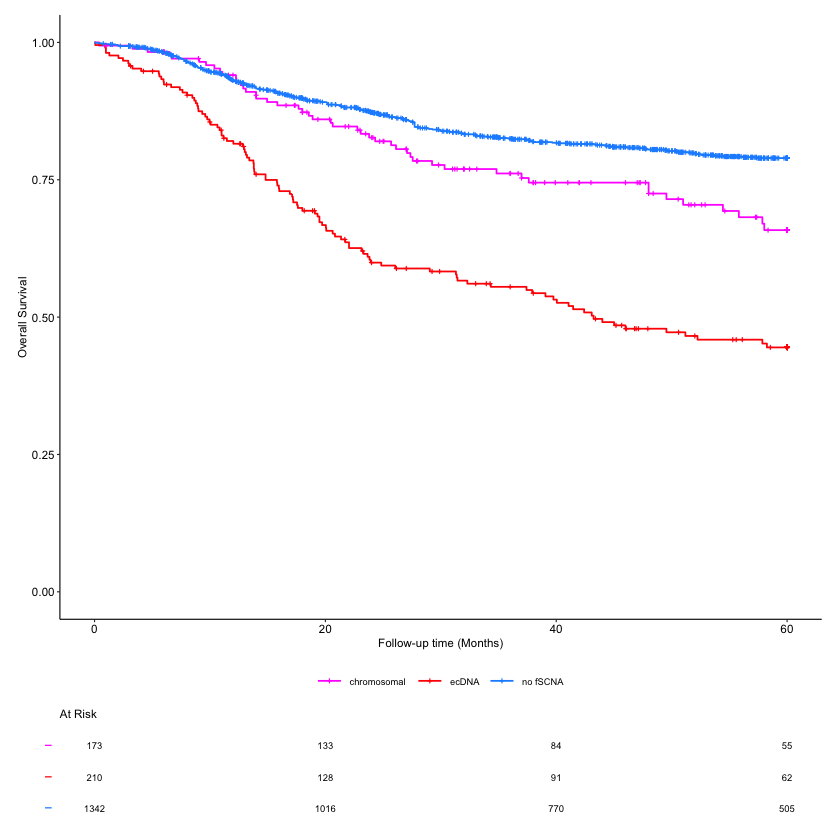

In [12]:
# KM by ecDNA status of tumor types with at least 1 sample with ecDNA, censored at 5 years
class_map <- c("ecDNA" = "ecDNA",
               "BFB" = "chromosomal",
               "Complex noncyclic" = "chromosomal",
               "Linear" = "chromosomal"
)
dd2 <- load_survival_data("../data/Supplementary Tables With ICGC.xlsx") %>%
  mutate(amplicon_class = recode(amplicon_class, !!!class_map)) %>%
  group_by(cancer_type) %>%
  filter(any(amplicon_class == 'ecDNA')) %>%
  ungroup()
dd2$cancer_type <- droplevels(dd2$cancer_type) # drop unused levels
dd2$cancer_type %>% unique() # print remaining levels

formula = Surv(OS_months_5y, OS_status_5y) ~ amplicon_class
km = survfit2(formula=formula, data = dd2 )
#km_plot(km, "km_class_subset_5year")
km_plot(km)
logrank <- pairwise_survdiff(formula,dd2,p.adjust.method="BH",rho=0)
logrank

In [14]:
dd3 <-load_survival_data("../data/Supplementary Tables With ICGC.xlsx") %>%
  group_by(cancer_type) %>%
  filter(any(amplicon_class == 'ecDNA')) %>%
  filter(n() >= 10) %>%
  ungroup()
dim(dd3)
dd3$cancer_type %>% unique()
dd3$cancer_type <- droplevels(dd3$cancer_type)

dd3 %>% group_by(ecDNA_status, cancer_type) %>%
  summarise(n=n())%>%
  spread(cancer_type, n)
m1_unstrat <- coxph(Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + cancer_type, data = dd3)
m1_unstrat
#adding sex to the cox regression
m3 <- coxph(Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + cancer_type + sex, data = dd3)
m3
#adding age at diagnosis to the cox regression
m4 <- coxph(Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + sex, data = dd3)
m4
# Check proportionality assumption
coxZph <-cox.zph(m1_unstrat) 
print("coxZph: ")
print(coxZph)

#The `cox.zph()` function tests the proportionality assumption. The result is borderline, suggesting that this 
#assumption may be violated w.r.t. the cancer_type variable. 
#Therefore, we perform Cox regression w.r.t. ecDNA, stratifying by cancer_type. The result is the unchanged.

m1 <- coxph(Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + age_at_diagnosis, data = dd3)
m1
# Check proportionality assumption
coxZph <-cox.zph(m1) 
print("coxZph: ")
print(coxZph)

[1] 1704   12

[1] EPN  HGG  LGG  SARC NBL  CPG  MBL  CPT  GCT  PBL  EMBT OST  RBL  RMS  WLM 
45 Levels: ACC ATRT BENG BTNOS CARC CHDM CNSL CPG CPT DSRCT EBVT EMBT ... WLM

`summarise()` has grouped output by 'ecDNA_status'. You can override using the
`.groups` argument.


ecDNA_status,CPG,CPT,EMBT,EPN,GCT,HGG,LGG,MBL,NBL,OST,PBL,RBL,RMS,SARC,WLM
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ecDNA-,77,36,12,123,32,222,444,357,50,28,16,24,22,32,27
ecDNA+,1,3,3,1,2,54,1,73,11,26,1,6,14,5,1


Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  12 ; coefficient may be infinite. ”


Call:
coxph(formula = Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + 
    cancer_type, data = dd3)

                         coef  exp(coef)   se(coef)      z        p
ecDNA_statusecDNA+  5.716e-01  1.771e+00  1.210e-01  4.726 2.29e-06
cancer_typeCPT      7.210e-01  2.057e+00  7.074e-01  1.019  0.30805
cancer_typeEMBT     2.085e+00  8.045e+00  6.715e-01  3.105  0.00190
cancer_typeEPN      9.174e-01  2.503e+00  5.590e-01  1.641  0.10078
cancer_typeGCT      8.296e-02  1.086e+00  8.660e-01  0.096  0.92369
cancer_typeHGG      3.109e+00  2.241e+01  5.060e-01  6.145 8.00e-10
cancer_typeLGG     -1.199e+00  3.015e-01  6.268e-01 -1.913  0.05580
cancer_typeMBL      1.221e+00  3.390e+00  5.131e-01  2.379  0.01735
cancer_typeNBL      1.009e+00  2.742e+00  5.844e-01  1.726  0.08433
cancer_typeOST      1.582e+00  4.865e+00  5.516e-01  2.868  0.00413
cancer_typePBL      1.481e+00  4.398e+00  7.638e-01  1.939  0.05247
cancer_typeRBL     -1.502e+01  3.011e-07  1.179e+03 -0.013  0.98984
cancer_typeRM

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  12 ; coefficient may be infinite. ”


Call:
coxph(formula = Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + 
    cancer_type + sex, data = dd3)

                         coef  exp(coef)   se(coef)      z        p
ecDNA_statusecDNA+  5.826e-01  1.791e+00  1.224e-01  4.762 1.92e-06
cancer_typeCPT      9.565e-01  2.603e+00  7.641e-01  1.252  0.21062
cancer_typeEMBT     2.231e+00  9.305e+00  7.652e-01  2.915  0.00356
cancer_typeEPN      1.195e+00  3.304e+00  6.292e-01  1.899  0.05755
cancer_typeGCT      3.251e-01  1.384e+00  9.129e-01  0.356  0.72178
cancer_typeHGG      3.366e+00  2.895e+01  5.826e-01  5.777 7.62e-09
cancer_typeLGG     -9.357e-01  3.923e-01  6.901e-01 -1.356  0.17512
cancer_typeMBL      1.470e+00  4.351e+00  5.889e-01  2.497  0.01254
cancer_typeNBL      1.099e+00  3.001e+00  6.672e-01  1.647  0.09953
cancer_typeOST      1.770e+00  5.873e+00  6.248e-01  2.833  0.00461
cancer_typePBL      1.718e+00  5.572e+00  8.166e-01  2.104  0.03541
cancer_typeRBL     -1.490e+01  3.376e-07  1.255e+03 -0.012  0.99053
cancer_

Call:
coxph(formula = Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + 
    sex, data = dd3)

                       coef exp(coef) se(coef)      z      p
ecDNA_statusecDNA+  1.12887   3.09215  0.11785  9.579 <2e-16
sexMale            -0.09541   0.90900  0.10435 -0.914  0.361

Likelihood ratio test=76.34  on 2 df, p=< 2.2e-16
n= 1668, number of events= 372 
   (36 observations deleted due to missingness)

[1] "coxZph: "
                chisq df     p
ecDNA_status  0.00706  1 0.933
cancer_type  21.77743 14 0.083
GLOBAL       21.78046 15 0.114


Call:
coxph(formula = Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + 
    age_at_diagnosis, data = dd3)

                        coef exp(coef)  se(coef)     z      p
ecDNA_statusecDNA+ 1.106e+00 3.022e+00 1.287e-01 8.590 <2e-16
age_at_diagnosis   5.369e-06 1.000e+00 2.568e-05 0.209  0.834

Likelihood ratio test=60.64  on 2 df, p=6.804e-14
n= 1499, number of events= 338 
   (205 observations deleted due to missingness)

[1] "coxZph: "
                  chisq df       p
ecDNA_status      0.722  1 0.39543
age_at_diagnosis 13.377  1 0.00025
GLOBAL           13.658  2 0.00108
